In [2]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


In [3]:
import io
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
from scipy import stats
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.kernel_ridge import KernelRidge
from prophet import Prophet

In [4]:
historical_weather = pd.read_csv(r"C:\0A___________________________________\Predictor 1.0\historical_weather.csv")
test_data = pd.read_csv(r"C:\0A___________________________________\Predictor 1.0\submission_key.csv")

In [5]:
historical_weather.head()

,city_id,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh
0,C001,2014-01-01,6.6,-1.4,11.6,NaN,NaN,168.0,6.2
1,C001,2014-01-02,9.3,6.3,13.3,NaN,NaN,155.0,10.0
2,C001,2014-01-03,7.6,1.9,14.0,NaN,NaN,NaN,5.8
3,C001,2014-01-04,7.6,3.9,13.3,NaN,NaN,291.0,11.3
4,C001,2014-01-05,8.6,0.5,16.9,NaN,NaN,NaN,5.0


In [6]:
historical_weather.shape

(182338, 9)

In [7]:
test_data.shape

(700, 3)

In [8]:
historical_weather.describe()

,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh
count,181114.000000,176452.000000,174845.000000,112594.000000,12238.000000,146944.000000,159866.000000
mean,19.137516,14.627775,23.887261,3.679964,342.481696,175.650289,11.281875
std,9.902722,10.004998,10.446670,11.294167,1020.265388,105.435150,6.132884
min,-34.700000,-43.800000,-28.500000,0.000000,0.000000,0.000000,0.000000
25%,12.400000,7.500000,17.100000,0.000000,0.000000,83.000000,7.200000
50%,21.400000,16.200000,27.000000,0.000000,10.000000,178.000000,9.900000
75%,27.100000,23.300000,31.500000,2.300000,140.000000,266.000000,14.000000
max,41.900000,38.900000,49.100000,496.100000,7140.000000,360.000000,80.000000


In [9]:
historical_weather.dtypes[historical_weather.dtypes != 'object']

avg_temp_c            float64
min_temp_c            float64
max_temp_c            float64
precipitation_mm      float64
snow_depth_mm         float64
avg_wind_dir_deg      float64
avg_wind_speed_kmh    float64
dtype: object

In [10]:
historical_weather.dtypes[historical_weather.dtypes == 'object']

city_id    object
date       object
dtype: object

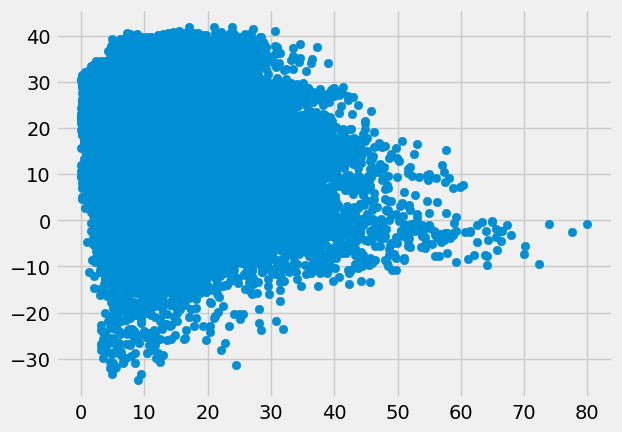

In [11]:
plt.scatter(x='avg_wind_speed_kmh', y='avg_temp_c', data=historical_weather)

In [12]:
#Missing value handling

In [13]:
pd.DataFrame(historical_weather.isnull().sum().sort_values(ascending=False)).head(20)

,0
snow_depth_mm,170100
precipitation_mm,69744
avg_wind_dir_deg,35394
avg_wind_speed_kmh,22472
max_temp_c,7493
min_temp_c,5886
avg_temp_c,1224
city_id,0
date,0


In [14]:
##Drop snow_depth_mm column

In [15]:
historical_weather.drop(columns=['snow_depth_mm'], inplace=True)

In [16]:
# num_cols = historical_weather.select_dtypes(include=['int64', 'float64']).columns

In [17]:
# num_pipeline = Pipeline(steps=[
#     ('impute', SimpleImputer(strategy='mean')),
#     ('scaler', StandardScaler())
# ])

In [18]:
# col_trans = ColumnTransformer(transformers=[
#     ('num_p', num_pipeline, num_cols)
#     ],
#     remainder='passthrough', 
#     n_jobs=-1)

In [19]:
#  pipeline = Pipeline(steps=[
#     ('preprocessing', col_trans)
# ])

In [20]:
# preprocessed = pipeline.fit_transform(historical_weather)

In [21]:
# historical_weather = pd.DataFrame(historical_weather)

In [22]:
#Feature Engineering

In [23]:
print(type(historical_weather))

<class 'pandas.core.frame.DataFrame'>


In [24]:
# historical_weather = historical_weather.drop(columns=['precipitation_mm', 'avg_wind_dir_deg', 'avg_wind_speed_kmh', 'max_temp_c', 'min_temp_c'])

In [25]:
historical_weather['date'] = pd.to_datetime(historical_weather['date'])
test_data['date'] = pd.to_datetime(test_data['date'])

In [26]:
historical_weather['city_id'] = historical_weather['city_id'].str.extract('(\d+)').astype(int)
test_data['city_id'] = test_data['city_id'].str.extract('(\d+)').astype(int)

historical_df = historical_weather.copy()

In [27]:
historical_weather['city_id'].unique()

array([  1,   2,   3,   4,   5,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  20,  22,  23,  24,  25,  27,  28,  29,  30,
        31,  33,  34,  35,  36,  37,  38,  39,  40,  42,  43,  44,  45,
        46,  47,  48,  49,  51,  53,  54,  55,  56,  57,  58,  59,  61,
        62,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  76,
        77,  78,  79,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112])

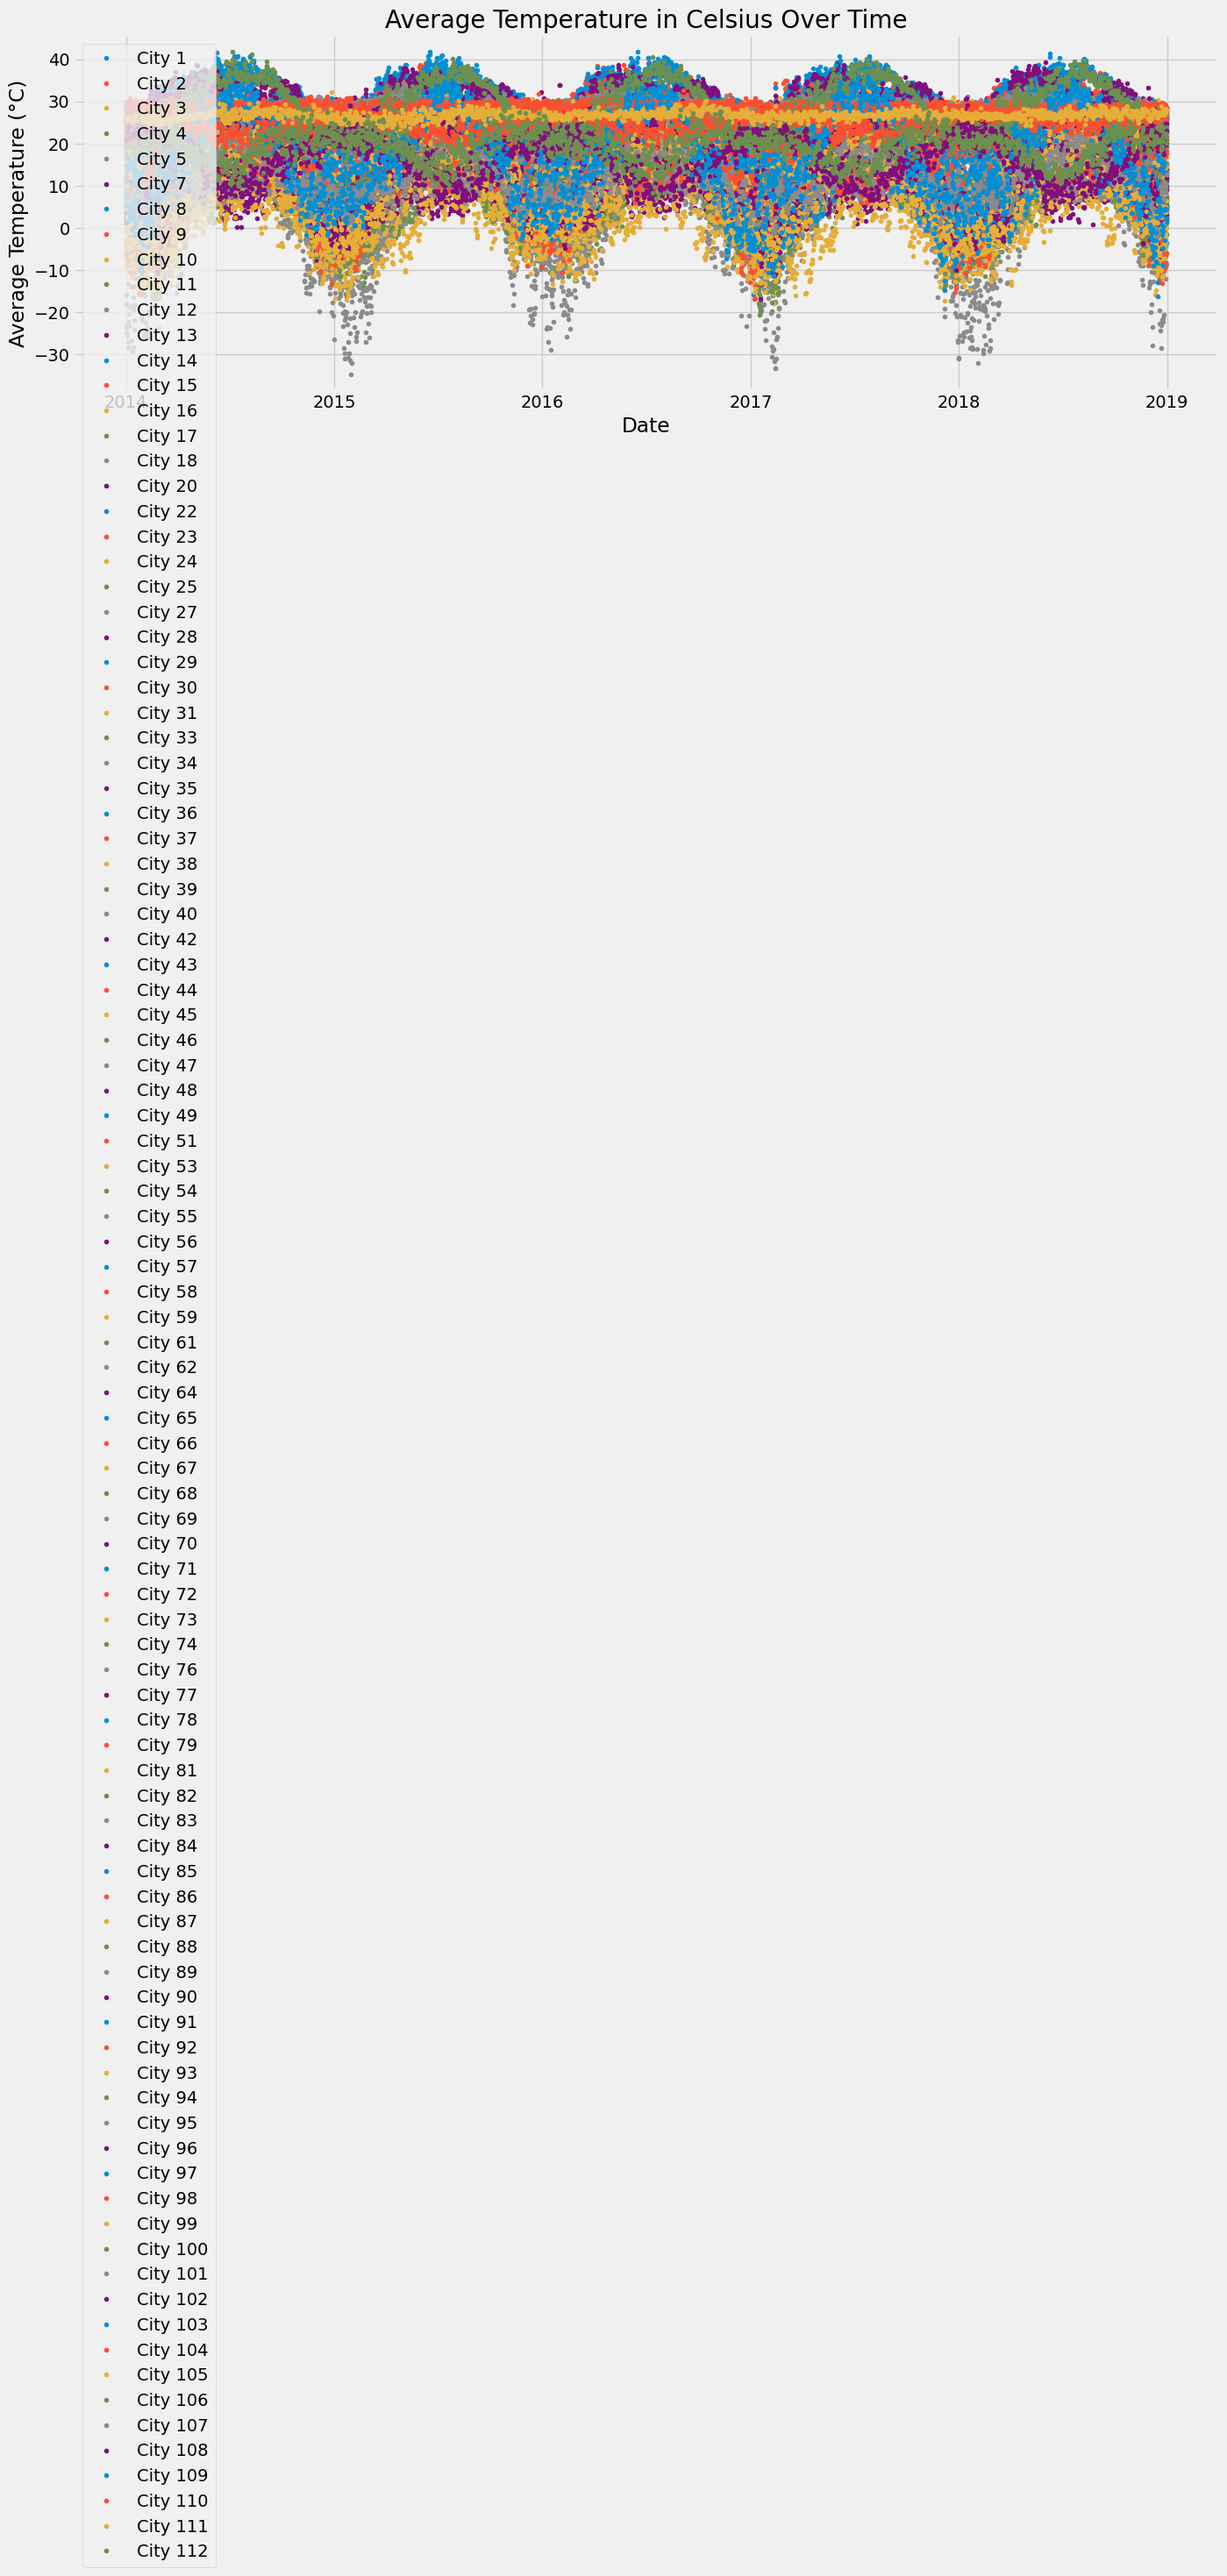

In [28]:
plt.figure(figsize=(15, 5))
for city in historical_weather['city_id'].unique():
    city_data = historical_weather[historical_weather['city_id'] == city]
    plt.plot(city_data['date'], city_data['avg_temp_c'], '.', label=f'City {city}')

plt.title('Average Temperature in Celsius Over Time')
plt.xlabel('Date')
plt.ylabel('Average Temperature (°C)')
plt.legend(loc='best')
plt.show()

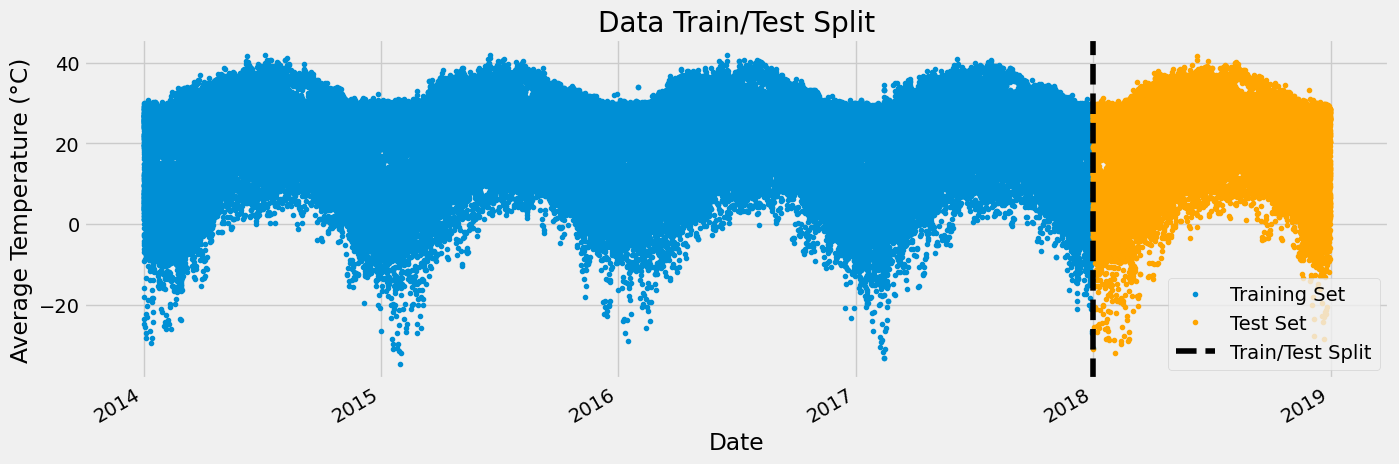

In [29]:
train = historical_weather.loc[historical_weather['date'] < '01-01-2018']
test = historical_weather.loc[historical_weather['date'] >= '01-01-2018']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(x='date', y='avg_temp_c', ax=ax, label='Training Set', style='.')
test.plot(x='date', y='avg_temp_c', ax=ax, label='Test Set', style='.', color='orange')
ax.axvline(pd.to_datetime('01-01-2018'), color='black', ls='--')
ax.set_title('Data Train/Test Split')
ax.set_xlabel('Date')
ax.set_ylabel('Average Temperature (°C)')
ax.legend(['Training Set', 'Test Set', 'Train/Test Split'])

plt.show()

In [30]:
cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter'])
    df['season'] = df['season'].cat.codes
    return df

historical_weather = create_features(historical_weather)

In [31]:
historical_weather.head()

,city_id,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,avg_wind_dir_deg,avg_wind_speed_kmh,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,date_offset,season
0,1,2014-01-01,6.6,-1.4,11.6,NaN,168.0,6.2,2,1,1,2014,1,1,1,1081,3
1,1,2014-01-02,9.3,6.3,13.3,NaN,155.0,10.0,3,1,1,2014,2,2,1,1082,3
2,1,2014-01-03,7.6,1.9,14.0,NaN,NaN,5.8,4,1,1,2014,3,3,1,1083,3
3,1,2014-01-04,7.6,3.9,13.3,NaN,291.0,11.3,5,1,1,2014,4,4,1,1084,3
4,1,2014-01-05,8.6,0.5,16.9,NaN,NaN,5.0,6,1,1,2014,5,5,1,1085,3


In [32]:
historical_weather = historical_weather.drop(columns=['precipitation_mm', 'avg_wind_dir_deg', 'avg_wind_speed_kmh', 'max_temp_c', 'min_temp_c'])

In [33]:
historical_weather.head()

,city_id,date,avg_temp_c,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,date_offset,season
0,1,2014-01-01,6.6,2,1,1,2014,1,1,1,1081,3
1,1,2014-01-02,9.3,3,1,1,2014,2,2,1,1082,3
2,1,2014-01-03,7.6,4,1,1,2014,3,3,1,1083,3
3,1,2014-01-04,7.6,5,1,1,2014,4,4,1,1084,3
4,1,2014-01-05,8.6,6,1,1,2014,5,5,1,1085,3


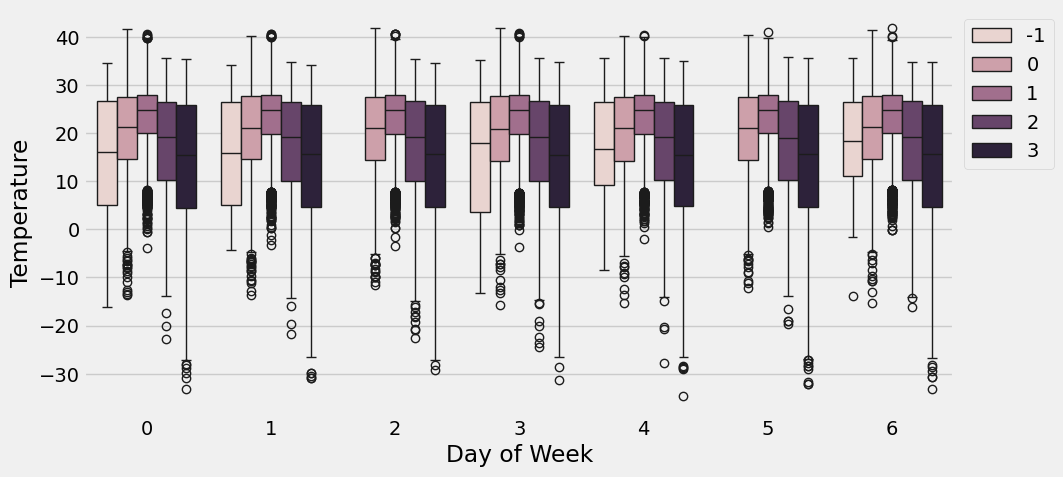

In [34]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=historical_weather.dropna(),
            x='dayofweek',
            y='avg_temp_c',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_xlabel('Day of Week')
ax.set_ylabel('Temperature')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

In [35]:
#missing values handling

In [36]:
imputer = SimpleImputer(strategy='mean')

In [37]:
historical_weather['avg_temp_c'] = imputer.fit_transform(historical_weather[['avg_temp_c']])
historical_df['avg_temp_c'] = imputer.fit_transform(historical_df[['avg_temp_c']])


In [38]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
# historical_weather = historical_weather.sort_index()

In [39]:
historical_weather['year'].unique()

array([2014, 2015, 2016, 2017, 2018])

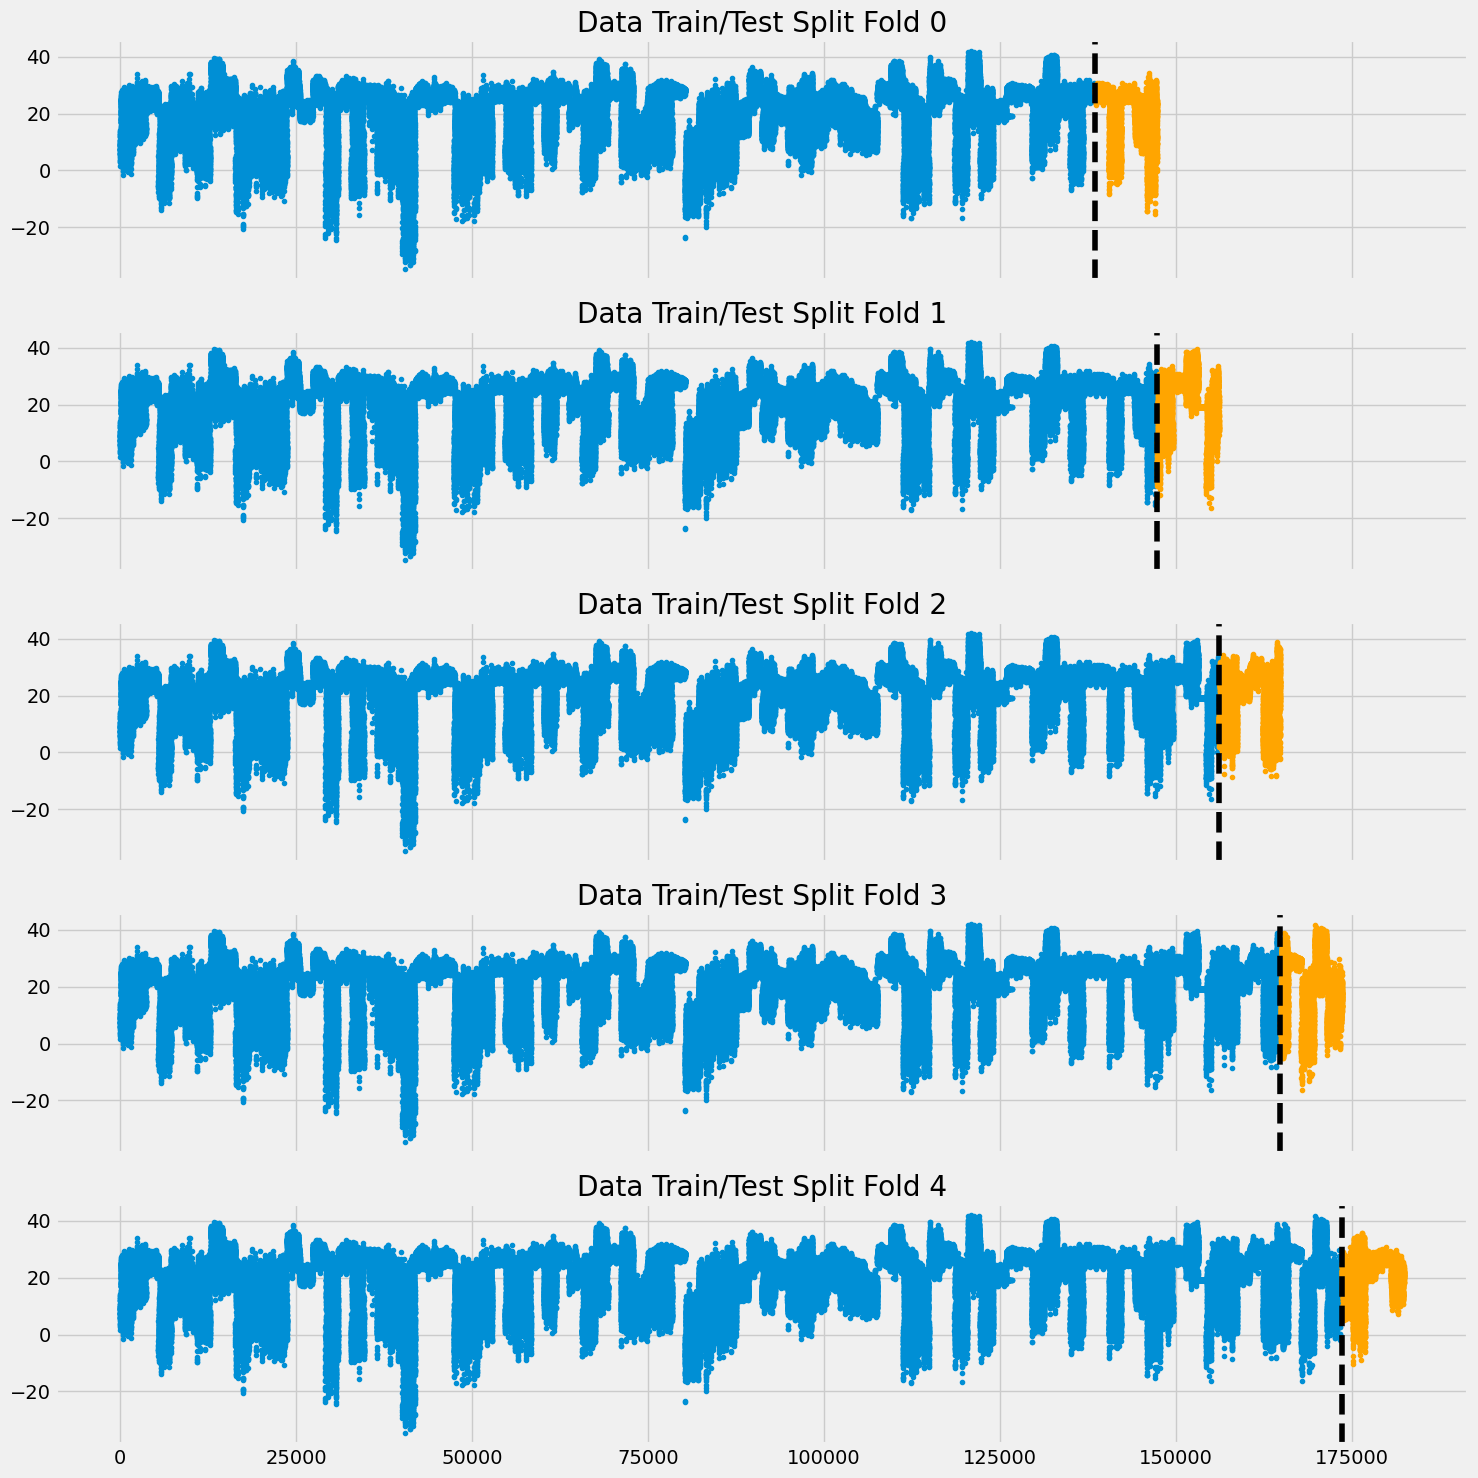

In [40]:
historical_weather['date'] = pd.to_datetime(historical_weather['date'])
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(historical_weather):
    train = historical_weather.iloc[train_idx]
    test = historical_weather.iloc[val_idx]
    train['avg_temp_c'].plot(x='date',ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}',style='.')
    test['avg_temp_c'].plot(x='date',ax=axs[fold],
                         label='Test Set',style='.',color='orange')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.tight_layout()
plt.show()

In [41]:
# historical_weather = historical_weather.drop(columns=['date'])

In [42]:
historical_weather

,city_id,date,avg_temp_c,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,date_offset,season
0,1,2014-01-01,6.6,2,1,1,2014,1,1,1,1081,3
1,1,2014-01-02,9.3,3,1,1,2014,2,2,1,1082,3
2,1,2014-01-03,7.6,4,1,1,2014,3,3,1,1083,3
3,1,2014-01-04,7.6,5,1,1,2014,4,4,1,1084,3
4,1,2014-01-05,8.6,6,1,1,2014,5,5,1,1085,3
...,...,...,...,...,...,...,...,...,...,...,...,...
182333,112,2018-12-27,22.0,3,4,12,2018,361,27,52,907,3
182334,112,2018-12-28,21.9,4,4,12,2018,362,28,52,908,3
182335,112,2018-12-29,22.4,5,4,12,2018,363,29,52,909,3
182336,112,2018-12-30,21.6,6,4,12,2018,364,30,52,910,3


In [43]:
def create_lag_features(df, lags, cols):
    for col in cols:
        for lag in lags:
            df[f'{col}_lag_{lag}'] = df.groupby('city_id')[col].shift(lag)
    return df

In [44]:
lag_features = ['avg_temp_c']
lags = [1, 2, 3, 4, 5, 6, 7]  # 1-day, 2-day, 3-day, 7-day, 14-day, and 30-day lags
historical_weather = create_lag_features(historical_weather, lags, lag_features)

In [45]:
historical_weather.head()

,city_id,date,avg_temp_c,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,date_offset,season,avg_temp_c_lag_1,avg_temp_c_lag_2,avg_temp_c_lag_3,avg_temp_c_lag_4,avg_temp_c_lag_5,avg_temp_c_lag_6,avg_temp_c_lag_7
0,1,2014-01-01,6.6,2,1,1,2014,1,1,1,1081,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2014-01-02,9.3,3,1,1,2014,2,2,1,1082,3,6.6,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2014-01-03,7.6,4,1,1,2014,3,3,1,1083,3,9.3,6.6,NaN,NaN,NaN,NaN,NaN
3,1,2014-01-04,7.6,5,1,1,2014,4,4,1,1084,3,7.6,9.3,6.6,NaN,NaN,NaN,NaN
4,1,2014-01-05,8.6,6,1,1,2014,5,5,1,1085,3,7.6,7.6,9.3,6.6,NaN,NaN,NaN


In [46]:
historical_weather = historical_weather.dropna()

<Axes: >

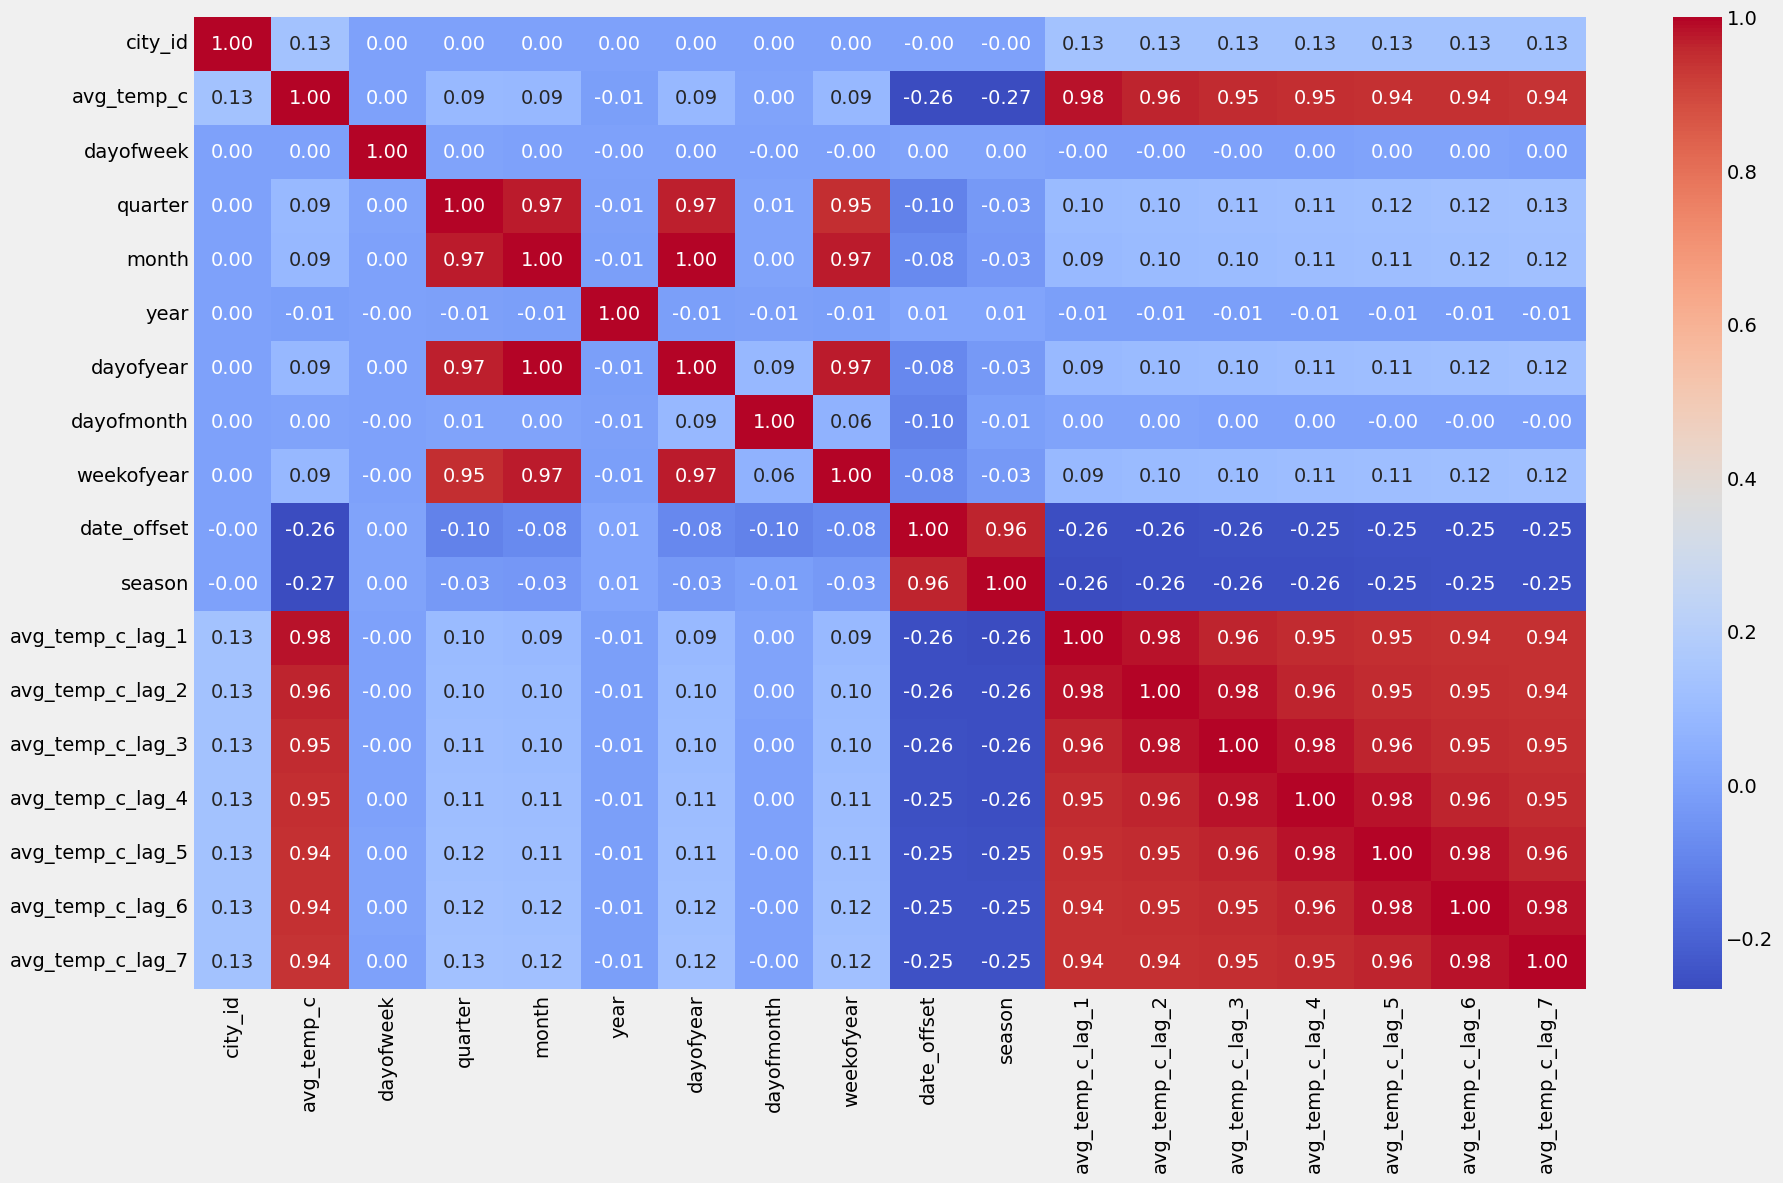

In [47]:
correlation_matrix = historical_weather.corr(numeric_only=True)
plt.figure(figsize=(20,12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm',fmt=".2f")

In [48]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
historical_weather = historical_weather.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(historical_weather):
    train = historical_weather.iloc[train_idx]
    test = historical_weather.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['city_id','dayofweek','quarter', 'month','year', 'dayofyear','dayofmonth','weekofyear','date_offset','season','avg_temp_c_lag_1','avg_temp_c_lag_2',
                'avg_temp_c_lag_3','avg_temp_c_lag_4','avg_temp_c_lag_5','avg_temp_c_lag_6','avg_temp_c_lag_7']
    TARGET = 'avg_temp_c'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=50000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:20.61482	validation_1-rmse:21.61773


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [15:45:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:7.81661	validation_1-rmse:8.09113
[200]	validation_0-rmse:3.38453	validation_1-rmse:3.37761
[300]	validation_0-rmse:2.13657	validation_1-rmse:2.04918
[400]	validation_0-rmse:1.89173	validation_1-rmse:1.80196
[500]	validation_0-rmse:1.84946	validation_1-rmse:1.76468
[600]	validation_0-rmse:1.83849	validation_1-rmse:1.75798
[700]	validation_0-rmse:1.83284	validation_1-rmse:1.75679
[800]	validation_0-rmse:1.82910	validation_1-rmse:1.75576
[900]	validation_0-rmse:1.82525	validation_1-rmse:1.75399
[1000]	validation_0-rmse:1.82190	validation_1-rmse:1.75199
[1100]	validation_0-rmse:1.81895	validation_1-rmse:1.75033
[1200]	validation_0-rmse:1.81622	validation_1-rmse:1.74871
[1300]	validation_0-rmse:1.81380	validation_1-rmse:1.74728
[1400]	validation_0-rmse:1.81174	validation_1-rmse:1.74606
[1500]	validation_0-rmse:1.80976	validation_1-rmse:1.74497
[1600]	validation_0-rmse:1.80774	validation_1-rmse:1.74382
[1700]	validation_0-rmse:1.80580	validation_1-rmse:1.74279
[1800]

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [15:46:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:7.83673	validation_1-rmse:8.54240
[200]	validation_0-rmse:3.38893	validation_1-rmse:3.56283
[300]	validation_0-rmse:2.13518	validation_1-rmse:2.06665
[400]	validation_0-rmse:1.88932	validation_1-rmse:1.75048
[500]	validation_0-rmse:1.84696	validation_1-rmse:1.69774
[600]	validation_0-rmse:1.83617	validation_1-rmse:1.68703
[700]	validation_0-rmse:1.83087	validation_1-rmse:1.68374
[800]	validation_0-rmse:1.82673	validation_1-rmse:1.68215
[900]	validation_0-rmse:1.82299	validation_1-rmse:1.68077
[1000]	validation_0-rmse:1.81954	validation_1-rmse:1.67976
[1100]	validation_0-rmse:1.81663	validation_1-rmse:1.67918
[1200]	validation_0-rmse:1.81407	validation_1-rmse:1.67881
[1300]	validation_0-rmse:1.81180	validation_1-rmse:1.67860
[1400]	validation_0-rmse:1.80966	validation_1-rmse:1.67848
[1500]	validation_0-rmse:1.80757	validation_1-rmse:1.67815
[1600]	validation_0-rmse:1.80557	validation_1-rmse:1.67784
[1700]	validation_0-rmse:1.80363	validation_1-rmse:1.67762
[1800]

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [15:46:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:7.87327	validation_1-rmse:8.10525
[200]	validation_0-rmse:3.39668	validation_1-rmse:3.45753
[300]	validation_0-rmse:2.13170	validation_1-rmse:2.09885
[400]	validation_0-rmse:1.88312	validation_1-rmse:1.82085
[500]	validation_0-rmse:1.84044	validation_1-rmse:1.77347
[600]	validation_0-rmse:1.82965	validation_1-rmse:1.76470
[700]	validation_0-rmse:1.82425	validation_1-rmse:1.76188
[800]	validation_0-rmse:1.82044	validation_1-rmse:1.76048
[900]	validation_0-rmse:1.81688	validation_1-rmse:1.75925
[1000]	validation_0-rmse:1.81366	validation_1-rmse:1.75774
[1100]	validation_0-rmse:1.81075	validation_1-rmse:1.75630
[1200]	validation_0-rmse:1.80797	validation_1-rmse:1.75509
[1300]	validation_0-rmse:1.80567	validation_1-rmse:1.75427
[1400]	validation_0-rmse:1.80358	validation_1-rmse:1.75344
[1500]	validation_0-rmse:1.80151	validation_1-rmse:1.75276
[1600]	validation_0-rmse:1.79942	validation_1-rmse:1.75204
[1700]	validation_0-rmse:1.79758	validation_1-rmse:1.75156
[1800]

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [15:47:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:7.88455	validation_1-rmse:8.40265
[200]	validation_0-rmse:3.39854	validation_1-rmse:3.66569
[300]	validation_0-rmse:2.13026	validation_1-rmse:2.23457
[400]	validation_0-rmse:1.88089	validation_1-rmse:1.92261
[500]	validation_0-rmse:1.83838	validation_1-rmse:1.86670
[600]	validation_0-rmse:1.82770	validation_1-rmse:1.85495
[700]	validation_0-rmse:1.82282	validation_1-rmse:1.85083
[800]	validation_0-rmse:1.81882	validation_1-rmse:1.84830
[900]	validation_0-rmse:1.81521	validation_1-rmse:1.84543
[1000]	validation_0-rmse:1.81200	validation_1-rmse:1.84331
[1100]	validation_0-rmse:1.80903	validation_1-rmse:1.84024
[1200]	validation_0-rmse:1.80639	validation_1-rmse:1.83748
[1300]	validation_0-rmse:1.80411	validation_1-rmse:1.83559
[1400]	validation_0-rmse:1.80208	validation_1-rmse:1.83416
[1500]	validation_0-rmse:1.80014	validation_1-rmse:1.83309
[1600]	validation_0-rmse:1.79828	validation_1-rmse:1.83180
[1700]	validation_0-rmse:1.79642	validation_1-rmse:1.83097
[1800]

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [15:48:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:7.90102	validation_1-rmse:7.89540
[200]	validation_0-rmse:3.40433	validation_1-rmse:3.30227
[300]	validation_0-rmse:2.13252	validation_1-rmse:2.05374
[400]	validation_0-rmse:1.88233	validation_1-rmse:1.83062
[500]	validation_0-rmse:1.83959	validation_1-rmse:1.80130
[600]	validation_0-rmse:1.82884	validation_1-rmse:1.79815
[683]	validation_0-rmse:1.82429	validation_1-rmse:1.79822


In [49]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 1.7570
Fold scores:[1.7316322628563043, 1.67690171772038, 1.7492732668722788, 1.8292307377093437, 1.7980608892654693]


In [50]:
# Retrain on all data
# historical_weather = create_features(historical_weather)

FEATURES = ['city_id','dayofweek','quarter', 'month','year', 'dayofyear','dayofmonth','weekofyear','date_offset','season','avg_temp_c_lag_1','avg_temp_c_lag_2',
                'avg_temp_c_lag_3','avg_temp_c_lag_4','avg_temp_c_lag_5','avg_temp_c_lag_6','avg_temp_c_lag_7']
TARGET = 'avg_temp_c'

X_all = historical_weather[FEATURES]
y_all = historical_weather[TARGET]

reg = XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=50000,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:20.89294


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [15:48:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:7.90881
[200]	validation_0-rmse:3.40591
[300]	validation_0-rmse:2.13163
[400]	validation_0-rmse:1.88124
[500]	validation_0-rmse:1.83863
[600]	validation_0-rmse:1.82825
[700]	validation_0-rmse:1.82297
[800]	validation_0-rmse:1.81947
[900]	validation_0-rmse:1.81611
[1000]	validation_0-rmse:1.81308
[1100]	validation_0-rmse:1.81032
[1200]	validation_0-rmse:1.80784
[1300]	validation_0-rmse:1.80581
[1400]	validation_0-rmse:1.80397
[1500]	validation_0-rmse:1.80209
[1600]	validation_0-rmse:1.80030
[1700]	validation_0-rmse:1.79861
[1800]	validation_0-rmse:1.79706
[1900]	validation_0-rmse:1.79546
[2000]	validation_0-rmse:1.79395
[2100]	validation_0-rmse:1.79244
[2200]	validation_0-rmse:1.79100
[2300]	validation_0-rmse:1.78968
[2400]	validation_0-rmse:1.78838
[2500]	validation_0-rmse:1.78710
[2600]	validation_0-rmse:1.78586
[2700]	validation_0-rmse:1.78471
[2800]	validation_0-rmse:1.78353
[2900]	validation_0-rmse:1.78238
[3000]	validation_0-rmse:1.78120
[3100]	validation_0

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [51]:
test_data['isFuture'] = True
historical_df['isFuture'] = False
df_and_future = pd.concat([historical_df, test_data])
df_and_future = create_features(df_and_future)
lag_features = ['avg_temp_c']
lags = [1, 2, 3, 4, 5, 6, 7] 
df_and_future = create_lag_features(df_and_future,lags,lag_features)


In [52]:
historical_weather

,city_id,date,avg_temp_c,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,date_offset,season,avg_temp_c_lag_1,avg_temp_c_lag_2,avg_temp_c_lag_3,avg_temp_c_lag_4,avg_temp_c_lag_5,avg_temp_c_lag_6,avg_temp_c_lag_7
7,1,2014-01-08,8.8,2,1,1,2014,8,8,2,1088,3,8.8,9.1,8.6,7.6,7.6,9.3,6.6
8,1,2014-01-09,9.9,3,1,1,2014,9,9,2,1089,3,8.8,8.8,9.1,8.6,7.6,7.6,9.3
9,1,2014-01-10,10.8,4,1,1,2014,10,10,2,1090,3,9.9,8.8,8.8,9.1,8.6,7.6,7.6
10,1,2014-01-11,10.2,5,1,1,2014,11,11,2,1091,3,10.8,9.9,8.8,8.8,9.1,8.6,7.6
11,1,2014-01-12,9.4,6,1,1,2014,12,12,2,1092,3,10.2,10.8,9.9,8.8,8.8,9.1,8.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182333,112,2018-12-27,22.0,3,4,12,2018,361,27,52,907,3,22.3,21.9,20.6,19.3,18.5,19.2,21.0
182334,112,2018-12-28,21.9,4,4,12,2018,362,28,52,908,3,22.0,22.3,21.9,20.6,19.3,18.5,19.2
182335,112,2018-12-29,22.4,5,4,12,2018,363,29,52,909,3,21.9,22.0,22.3,21.9,20.6,19.3,18.5
182336,112,2018-12-30,21.6,6,4,12,2018,364,30,52,910,3,22.4,21.9,22.0,22.3,21.9,20.6,19.3


In [53]:
df_and_future

,city_id,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,avg_wind_dir_deg,avg_wind_speed_kmh,isFuture,submission_ID,...,weekofyear,date_offset,season,avg_temp_c_lag_1,avg_temp_c_lag_2,avg_temp_c_lag_3,avg_temp_c_lag_4,avg_temp_c_lag_5,avg_temp_c_lag_6,avg_temp_c_lag_7
0,1,2014-01-01,6.6,-1.4,11.6,NaN,168.0,6.2,False,NaN,...,1,1081,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2014-01-02,9.3,6.3,13.3,NaN,155.0,10.0,False,NaN,...,1,1082,3,6.6,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2014-01-03,7.6,1.9,14.0,NaN,NaN,5.8,False,NaN,...,1,1083,3,9.3,6.6,NaN,NaN,NaN,NaN,NaN
3,1,2014-01-04,7.6,3.9,13.3,NaN,291.0,11.3,False,NaN,...,1,1084,3,7.6,9.3,6.6,NaN,NaN,NaN,NaN
4,1,2014-01-05,8.6,0.5,16.9,NaN,NaN,5.0,False,NaN,...,1,1085,3,7.6,7.6,9.3,6.6,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,112,2019-01-03,NaN,NaN,NaN,NaN,NaN,NaN,True,696.0,...,1,1083,3,NaN,NaN,20.2,21.6,22.4,21.9,22.0
696,112,2019-01-04,NaN,NaN,NaN,NaN,NaN,NaN,True,697.0,...,1,1084,3,NaN,NaN,NaN,20.2,21.6,22.4,21.9
697,112,2019-01-05,NaN,NaN,NaN,NaN,NaN,NaN,True,698.0,...,1,1085,3,NaN,NaN,NaN,NaN,20.2,21.6,22.4
698,112,2019-01-06,NaN,NaN,NaN,NaN,NaN,NaN,True,699.0,...,1,1086,3,NaN,NaN,NaN,NaN,NaN,20.2,21.6


In [54]:
future_w_features = df_and_future.query('isFuture').copy()

In [55]:
features = ['submission_ID','city_id','dayofweek','quarter', 'month','year', 'dayofyear','dayofmonth','weekofyear','date_offset','season','avg_temp_c_lag_1','avg_temp_c_lag_2',
                'avg_temp_c_lag_3','avg_temp_c_lag_4','avg_temp_c_lag_5','avg_temp_c_lag_6','avg_temp_c_lag_7']
future_w_features  = future_w_features[features].sort_values(by='submission_ID', ascending=True).drop(columns=['submission_ID'])

future_w_features

,city_id,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,date_offset,season,avg_temp_c_lag_1,avg_temp_c_lag_2,avg_temp_c_lag_3,avg_temp_c_lag_4,avg_temp_c_lag_5,avg_temp_c_lag_6,avg_temp_c_lag_7
0,1,1,1,1,2019,1,1,1,1081,3,11.8,10.7,8.9,10.1,9.7,9.4,9.0
1,1,2,1,1,2019,2,2,1,1082,3,NaN,11.8,10.7,8.9,10.1,9.7,9.4
2,1,3,1,1,2019,3,3,1,1083,3,NaN,NaN,11.8,10.7,8.9,10.1,9.7
3,1,4,1,1,2019,4,4,1,1084,3,NaN,NaN,NaN,11.8,10.7,8.9,10.1
4,1,5,1,1,2019,5,5,1,1085,3,NaN,NaN,NaN,NaN,11.8,10.7,8.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,112,3,1,1,2019,3,3,1,1083,3,NaN,NaN,20.2,21.6,22.4,21.9,22.0
696,112,4,1,1,2019,4,4,1,1084,3,NaN,NaN,NaN,20.2,21.6,22.4,21.9
697,112,5,1,1,2019,5,5,1,1085,3,NaN,NaN,NaN,NaN,20.2,21.6,22.4
698,112,6,1,1,2019,6,6,1,1086,3,NaN,NaN,NaN,NaN,NaN,20.2,21.6


In [56]:
pd.DataFrame(future_w_features.isnull().sum().sort_values(ascending=False)).head(20)

,0
avg_temp_c_lag_1,600
avg_temp_c_lag_2,500
avg_temp_c_lag_3,400
avg_temp_c_lag_4,300
avg_temp_c_lag_5,200
avg_temp_c_lag_6,100
city_id,0
season,0
date_offset,0
dayofweek,0


In [57]:
# future_w_features = future_w_features.fillna(0.0)

In [58]:
pd.DataFrame(future_w_features.isnull().sum().sort_values(ascending=False)).head(20)

,0
avg_temp_c_lag_1,600
avg_temp_c_lag_2,500
avg_temp_c_lag_3,400
avg_temp_c_lag_4,300
avg_temp_c_lag_5,200
avg_temp_c_lag_6,100
city_id,0
season,0
date_offset,0
dayofweek,0


In [59]:
df = historical_weather[['date','avg_temp_c']].copy()

In [60]:
df

,date,avg_temp_c
7,2014-01-08,8.8
8,2014-01-09,9.9
9,2014-01-10,10.8
10,2014-01-11,10.2
11,2014-01-12,9.4
...,...,...
182333,2018-12-27,22.0
182334,2018-12-28,21.9
182335,2018-12-29,22.4
182336,2018-12-30,21.6


In [61]:
split_date = '2017-01-01'
pjme_train = historical_weather.loc[historical_weather['date'] <= split_date].copy()
pjme_test = historical_weather.loc[historical_weather['date'] > split_date].copy()

In [62]:
pjme_train_prophet = pjme_train.rename(columns={'date':'ds',
                     'avg_temp_c':'y'})
pjme_test_prophet = pjme_test.rename(columns={'date':'ds',
                     'avg_temp_c':'y'})

In [63]:
pd.DataFrame(pjme_test_prophet.isnull().sum().sort_values(ascending=False)).head(20)

,0
city_id,0
date_offset,0
avg_temp_c_lag_6,0
avg_temp_c_lag_5,0
avg_temp_c_lag_4,0
avg_temp_c_lag_3,0
avg_temp_c_lag_2,0
avg_temp_c_lag_1,0
season,0
weekofyear,0


In [64]:
model = Prophet()
model.add_regressor('city_id')
model.add_regressor('dayofweek')
model.add_regressor('quarter') 
model.add_regressor('month')
model.add_regressor('year') 
model.add_regressor('dayofyear')
model.add_regressor('dayofmonth')
model.add_regressor('weekofyear')
model.add_regressor('date_offset')
model.add_regressor('season')
model.add_regressor('avg_temp_c_lag_1')
model.add_regressor('avg_temp_c_lag_2')
model.add_regressor('avg_temp_c_lag_3')
model.add_regressor('avg_temp_c_lag_4')
model.add_regressor('avg_temp_c_lag_5')
model.add_regressor('avg_temp_c_lag_6')
model.add_regressor('avg_temp_c_lag_7')
model.fit(pjme_train_prophet)

15:58:46 - cmdstanpy - INFO - Chain [1] start processing
16:00:39 - cmdstanpy - INFO - Chain [1] done processing


In [66]:
pjme_test_prophet

,city_id,ds,y,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,date_offset,season,avg_temp_c_lag_1,avg_temp_c_lag_2,avg_temp_c_lag_3,avg_temp_c_lag_4,avg_temp_c_lag_5,avg_temp_c_lag_6,avg_temp_c_lag_7
1097,1,2017-01-02,9.6,0,1,1,2017,2,2,1,1082,3,8.2,10.9,12.6,12.8,11.8,10.7,13.8
1098,1,2017-01-03,12.3,1,1,1,2017,3,3,1,1083,3,9.6,8.2,10.9,12.6,12.8,11.8,10.7
1099,1,2017-01-04,10.1,2,1,1,2017,4,4,1,1084,3,12.3,9.6,8.2,10.9,12.6,12.8,11.8
1100,1,2017-01-05,10.1,3,1,1,2017,5,5,1,1085,3,10.1,12.3,9.6,8.2,10.9,12.6,12.8
1101,1,2017-01-06,10.8,4,1,1,2017,6,6,1,1086,3,10.1,10.1,12.3,9.6,8.2,10.9,12.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182333,112,2018-12-27,22.0,3,4,12,2018,361,27,52,907,3,22.3,21.9,20.6,19.3,18.5,19.2,21.0
182334,112,2018-12-28,21.9,4,4,12,2018,362,28,52,908,3,22.0,22.3,21.9,20.6,19.3,18.5,19.2
182335,112,2018-12-29,22.4,5,4,12,2018,363,29,52,909,3,21.9,22.0,22.3,21.9,20.6,19.3,18.5
182336,112,2018-12-30,21.6,6,4,12,2018,364,30,52,910,3,22.4,21.9,22.0,22.3,21.9,20.6,19.3


In [67]:
pjme_test_prophet['ds'] = pd.to_datetime(pjme_test_prophet['ds'])

# Ensure 'y' column is in numerical format, if needed
pjme_test_prophet['y'] = pd.to_numeric(pjme_test_prophet['y'])

pjme_test_fcst = model.predict(pjme_test_prophet)

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-02,19.146705,3.221671,24.699193,19.146705,19.146705,-5.168143,-5.168143,-5.168143,0.030482,0.030482,0.030482,-5.198624,-5.198624,-5.198624,0.0,0.0,0.0,13.978562
1,2017-01-02,19.146705,2.365646,24.885707,19.146705,19.146705,-5.168143,-5.168143,-5.168143,0.030482,0.030482,0.030482,-5.198624,-5.198624,-5.198624,0.0,0.0,0.0,13.978562
2,2017-01-02,19.146705,1.820830,25.304332,19.146705,19.146705,-5.168143,-5.168143,-5.168143,0.030482,0.030482,0.030482,-5.198624,-5.198624,-5.198624,0.0,0.0,0.0,13.978562
3,2017-01-02,19.146705,2.653853,25.468373,19.146705,19.146705,-5.168143,-5.168143,-5.168143,0.030482,0.030482,0.030482,-5.198624,-5.198624,-5.198624,0.0,0.0,0.0,13.978562
4,2017-01-02,19.146705,1.960104,25.789532,19.146705,19.146705,-5.168143,-5.168143,-5.168143,0.030482,0.030482,0.030482,-5.198624,-5.198624,-5.198624,0.0,0.0,0.0,13.978562


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


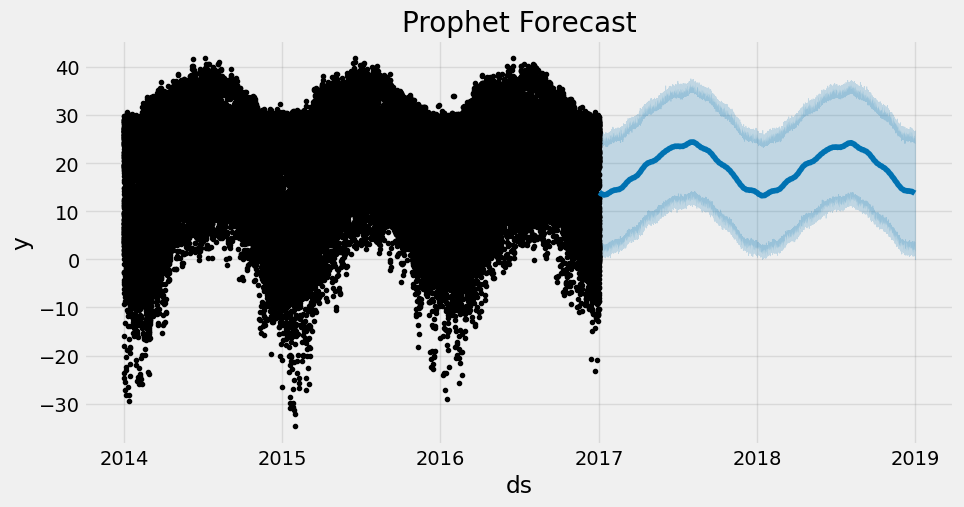

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

In [ ]:
np.sqrt(mean_squared_error(y_true=pjme_test['avg_temp_c'],
                   y_pred=pjme_test_fcst['yhat']))

10.469404517941719

In [ ]:
# future_w_features[['avg_temp_c_lag_1','avg_temp_c_lag_2','avg_temp_c_lag_3','avg_temp_c_lag_4','avg_temp_c_lag_5','avg_temp_c_lag_6']] = imputer.fit_transform(future_w_features[['avg_temp_c_lag_1','avg_temp_c_lag_2','avg_temp_c_lag_3','avg_temp_c_lag_4','avg_temp_c_lag_5','avg_temp_c_lag_6']])

In [ ]:
# Y_pred_1 = reg.predict(future_w_features)
# Y_pred_2 = reg.predict(future_w_features)
# Y_pred_4 = reg.predict(future_w_features)

In [ ]:
# submission_1 = pd.DataFrame({
#     'submission_ID': test_data['submission_ID'],
#     'avg_temp_c': Y_pred_1
# })
# submission_2 = pd.DataFrame({
#     'submission_ID': test_data['submission_ID'],
#     'avg_temp_c': Y_pred_2
# })
# submission_4 = pd.DataFrame({
#     'submission_ID': test_data['submission_ID'],
#     'avg_temp_c': Y_pred_4
# })

In [ ]:
# submission_1.to_csv("submission_1.csv", index=False)
# submission_2.to_csv("submission_2.csv", index=False)
# submission_4.to_csv("submission_4.csv", index=False)

In [ ]:
# X = historical_weather.drop(['avg_temp_c','date'],axis = 1)
# y = historical_weather['avg_temp_c']

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle= False)

In [ ]:
# pd.DataFrame(X_train.isnull().sum().sort_values(ascending=False)).head(20)

In [ ]:
# XGB = XGBRegressor(booster='gbtree',objective='reg:squarederror')

In [ ]:
# param_grid_XGB = {
#     'base_score':[0.5],
#     'learning_rate': [0.05,0.01, 0.1, 0.2],
#     'n_estimators': [1000],
#     'max_depth': [3],
#     'min_child_weight': [1,2,3],
#     'gamma': [0, 0.1, 0.2],
#     'subsample': [0.8, 0.9, 1.0],
#     'colsample_bytree': [0.8, 0.9, 1.0],
# }

In [ ]:
# xgb_cv = GridSearchCV(XGB, param_grid_XGB, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

In [ ]:
# xgb_cv.fit(X_train, y_train)

In [ ]:
# xgb_cv.best_estimator_

In [ ]:
# np.sqrt(-1 * xgb_cv.best_score_)

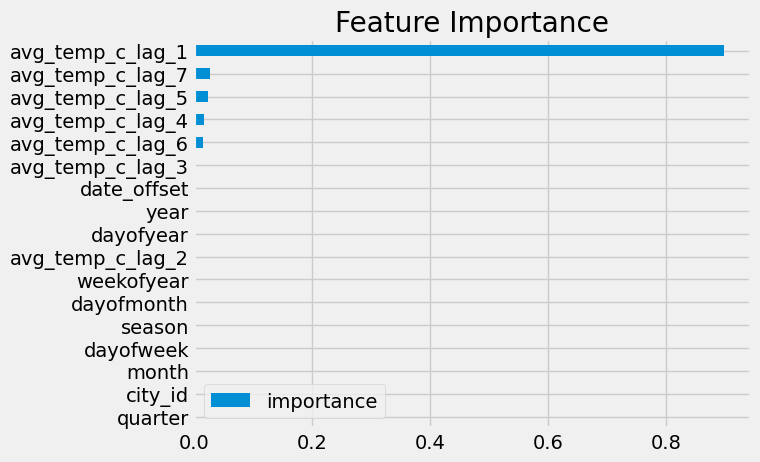

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [ ]:
# feature_importances = reg.best_estimator_.feature_importances_
# feature_names = reg.best_estimator_.feature_names_in_
# fi = pd.DataFrame(data=feature_importances,
#                   index=feature_names,
#                   columns=['importance'])
# fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
# plt.show()

In [ ]:
# ll=[]
# ll.append(np.abs(y_test - xgb_cv.predict(X_test)))
# ll


In [ ]:
# lr = LinearRegression()

In [ ]:
# lr.fit(X_train, y_train)

In [ ]:
# y_pred_lr = lr.predict(X_test)

In [ ]:
# np.sqrt(mean_squared_error(y_test, y_pred_lr))